# Human Segmentation Project

하나의 사진으로 배경과 피사체 구분하여 인물 모드 구현하기

## 1. 라이브러리 불러오기

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

## 2. 이미지 준비하기

(832, 554, 3)


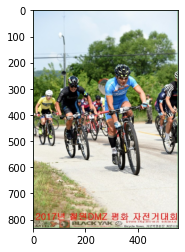

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bike1.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 3. 세그멘테이션으로 객체 분리하기


In [3]:
# PixelLib의 모델 다운로드 받기
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# urlretreive(url,filename): url의 파일 다운받아서 filename으로 저장
urllib.request.urlretrieve(model_url, model_file)


('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7c47411f27c0>)

In [4]:
#PixelLibe의 클래스를 sementic segmentation를 수행하는 클래스 인스턴스 만들기
model = semantic_segmentation()

#Pascal voc 데이터셋으로 훈련된 모델 로드하기
model.load_pascalvoc_model(model_file)

In [5]:
# 이미지 입력하기
segvalues, output = model.segmentAsPascalvoc(img_path)

In [6]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

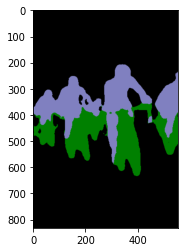

In [7]:
# 이미지 출력
plt.imshow(output)
plt.show()

## 4. 객체와 배경 분리하기

In [8]:
#입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력
segvalues

{'class_ids': array([ 0,  2, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
# 출력된 이미지의 클래스 확인하기
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bicycle
person


In [10]:
# 아래 코드를 이해하지 않아도 좋습니다

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [17]:
# person의 색상 코드 확인
print(colormap[15])
print(colormap[2])

[192 128 128]
[  0 128   0]


In [18]:
# colormap 출력 순서 (RGB) -> output 배열에 맞게 BGR 순서로 변경

seg_color1 = (128,128,192)
seg_color2 = (0, 128, 0)

객체 2를 묶어서 배경과 분리하기(bicycle, person)

(832, 554)


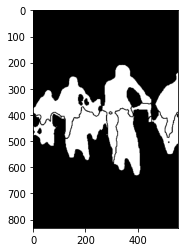

In [19]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all((output == seg_color1) | (output == seg_color2), axis=-1)
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

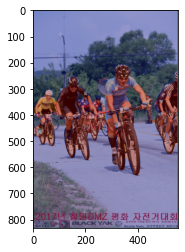

In [20]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 변경
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꾸기
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합치기
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 5. 배경 흐리게 설정하기

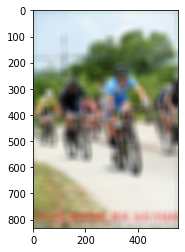

In [21]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (30,30))  # (30,30)로 변경하여 더 흐리게

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

블러 처리된 이미지에서 배경만 추출하기

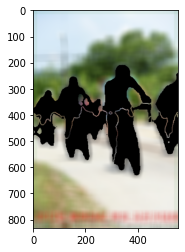

In [22]:
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 연산을 하고 나면 배경은 255 사람은 0
img_bg_mask = cv2.bitwise_not(img_mask_color)

# 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### bitwise 정리

cv2.bitwise_not(A) : 이미지 반전 , 0인 부분 ->255, 255인 부분 -> 0  
cv.bitwise_and(A, B) : A와 B 모두 0이 아닌 부분만 출력



## 6. 객체와 블러 처리된 배경 붙이기

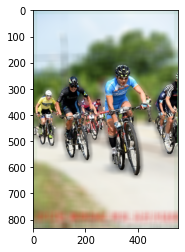

In [23]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

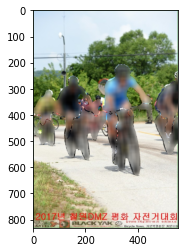

In [24]:
# 반대로 구현해보기

img_concat = np.where(img_mask_color!=255, img_orig, img_orig_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 다른 배경 설정하기
배경 준비

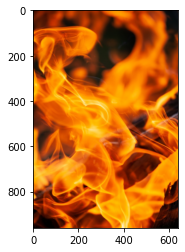

In [26]:
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/fire1.jpg'  
bg_orig = cv2.imread(bg_path) 

plt.imshow(cv2.cvtColor(bg_orig, cv2.COLOR_BGR2RGB))
plt.show()

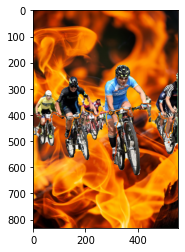

In [35]:
# img_orig에 맞춰서 리사이즈
resized_bg = cv2.resize(bg_orig, (554,832))

# print(img_orig.shape)
# print(resized_bg.shape)

img_concat = np.where(img_mask_color==255, img_orig, resized_bg)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()